# Random Forest for Seasonal Flu Target

In [100]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier

import xgboost as xgb

# Next two only necessary if target classes are imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

pd.set_option("display.max_columns", 50)
%matplotlib inline

random_state = 1232022
model_scoring_dict = {}

In [101]:
X = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

df = pd.concat([X, y], axis=1)

y_test_comp = pd.read_csv('data/test_set_features.csv')

In [102]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

In [104]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

In [105]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)
X_train_imp

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19184,3,2,1,1,0,1,1,1,1,0,0,0,0,1,1,4,2,1,4,2,1,18 - 34 Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,oxchjgsf,"MSA, Not Principle City",1,3,fcxhlnwr,cmhcxjea
11908,2,2,0,0,0,0,0,0,0,0,0,1,0,0,1,4,2,1,5,2,2,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1,0,fcxhlnwr,xtkaffoo
15188,0,2,0,1,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,bhuqouqj,"MSA, Not Principle City",1,0,atmlpfrs,hfxkjkmi
179,1,2,0,1,0,1,0,0,1,0,0,0,0,0,1,4,2,2,4,2,2,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000",Married,Own,Not in Labor Force,oxchjgsf,"MSA, Not Principle City",1,3,fcxhlnwr,xtkaffoo
6949,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,5,1,1,4,2,2,55 - 64 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,fpwskwrf,Non-MSA,0,0,fcxhlnwr,xtkaffoo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21465,2,2,0,1,0,1,0,0,1,0,0,0,0,0,1,3,3,2,3,4,2,65+ Years,College Graduate,Hispanic,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lzgpxyit,"MSA, Principle City",1,0,fcxhlnwr,xtkaffoo
3532,2,1,0,1,0,1,1,1,1,0,1,1,0,0,1,4,2,2,5,4,4,55 - 64 Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,atmpeygn,"MSA, Not Principle City",2,0,fcxhlnwr,xtkaffoo
5839,1,1,0,1,0,1,0,0,1,0,0,1,0,0,1,4,2,1,4,2,2,18 - 34 Years,Some College,Other or Multiple,Male,"<= $75,000, Above Poverty",Not Married,Own,Unemployed,dqpwygqj,Non-MSA,3,1,fcxhlnwr,xtkaffoo


In [75]:
X_train_dummied = pd.get_dummies(X_train_imp, drop_first=True, columns=['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status','hhs_geo_region','census_msa','employment_industry','employment_occupation'])
X_train_dummied

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_35 - 44 Years,age_group_45 - 54 Years,...,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19184,3,2,1,1,0,1,1,1,1,0,0,0,0,1,1,4,2,1,4,2,1,1,3,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11908,2,2,0,0,0,0,0,0,0,0,0,1,0,0,1,4,2,1,5,2,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15188,0,2,0,1,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
179,1,2,0,1,0,1,0,0,1,0,0,0,0,0,1,4,2,2,4,2,2,1,3,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6949,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,5,1,1,4,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21465,2,2,0,1,0,1,0,0,1,0,0,0,0,0,1,3,3,2,3,4,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3532,2,1,0,1,0,1,1,1,1,0,1,1,0,0,1,4,2,2,5,4,4,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5839,1,1,0,1,0,1,0,0,1,0,0,1,0,0,1,4,2,1,4,2,2,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [106]:
X_test_dummied = pd.get_dummies(X_test_imp, drop_first=True, columns=['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status','hhs_geo_region','census_msa','employment_industry','employment_occupation'])
X_test_dummied

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_35 - 44 Years,age_group_45 - 54 Years,...,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11527,3,2,1,1,1,1,1,0,1,1,1,1,0,0,1,5,4,4,5,5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
24842,3,1,0,1,0,1,0,0,1,0,0,0,0,0,1,5,4,4,4,4,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1102,2,1,0,1,0,1,1,1,1,0,0,0,0,0,1,4,2,4,4,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
13461,3,2,0,1,0,1,0,0,1,0,1,0,0,0,1,5,4,2,4,2,1,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
16793,0,0,0,1,0,1,1,1,1,0,0,0,1,0,0,4,4,4,4,4,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16061,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,4,2,2,2,1,2,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
22308,1,1,0,1,0,1,1,0,1,0,0,0,0,0,1,2,1,2,2,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
17658,3,1,0,1,0,0,1,0,0,0,0,0,0,0,1,3,2,4,4,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [107]:
X_test_dummied = X_test_dummied.reindex(columns = X_train_dummied.columns, fill_value=0)
X_test_dummied

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_35 - 44 Years,age_group_45 - 54 Years,...,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11527,3,2,1,1,1,1,1,0,1,1,1,1,0,0,1,5,4,4,5,5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
24842,3,1,0,1,0,1,0,0,1,0,0,0,0,0,1,5,4,4,4,4,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1102,2,1,0,1,0,1,1,1,1,0,0,0,0,0,1,4,2,4,4,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
13461,3,2,0,1,0,1,0,0,1,0,1,0,0,0,1,5,4,2,4,2,1,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
16793,0,0,0,1,0,1,1,1,1,0,0,0,1,0,0,4,4,4,4,4,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16061,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,4,2,2,2,1,2,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
22308,1,1,0,1,0,1,1,0,1,0,0,0,0,0,1,2,1,2,2,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
17658,3,1,0,1,0,0,1,0,0,0,0,0,0,0,1,3,2,4,4,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# Decision Tree Classifier

In [108]:
# Will only test seasonal flu data for now

#Build a regular decision tree as a baseline
from sklearn.tree import DecisionTreeClassifier

baseline_tree = DecisionTreeClassifier(random_state=42)
baseline_tree.fit(X_train_dummied, y_train_ssnl)

DecisionTreeClassifier(random_state=42)

In [109]:
baseline_tree.score(X_train_dummied, y_train_ssnl)

1.0

In [110]:
# Score for baseline decision tree -- Seasonal Flu test data
baseline_tree.score(X_test_dummied, y_test_ssnl)

0.6956196181205541

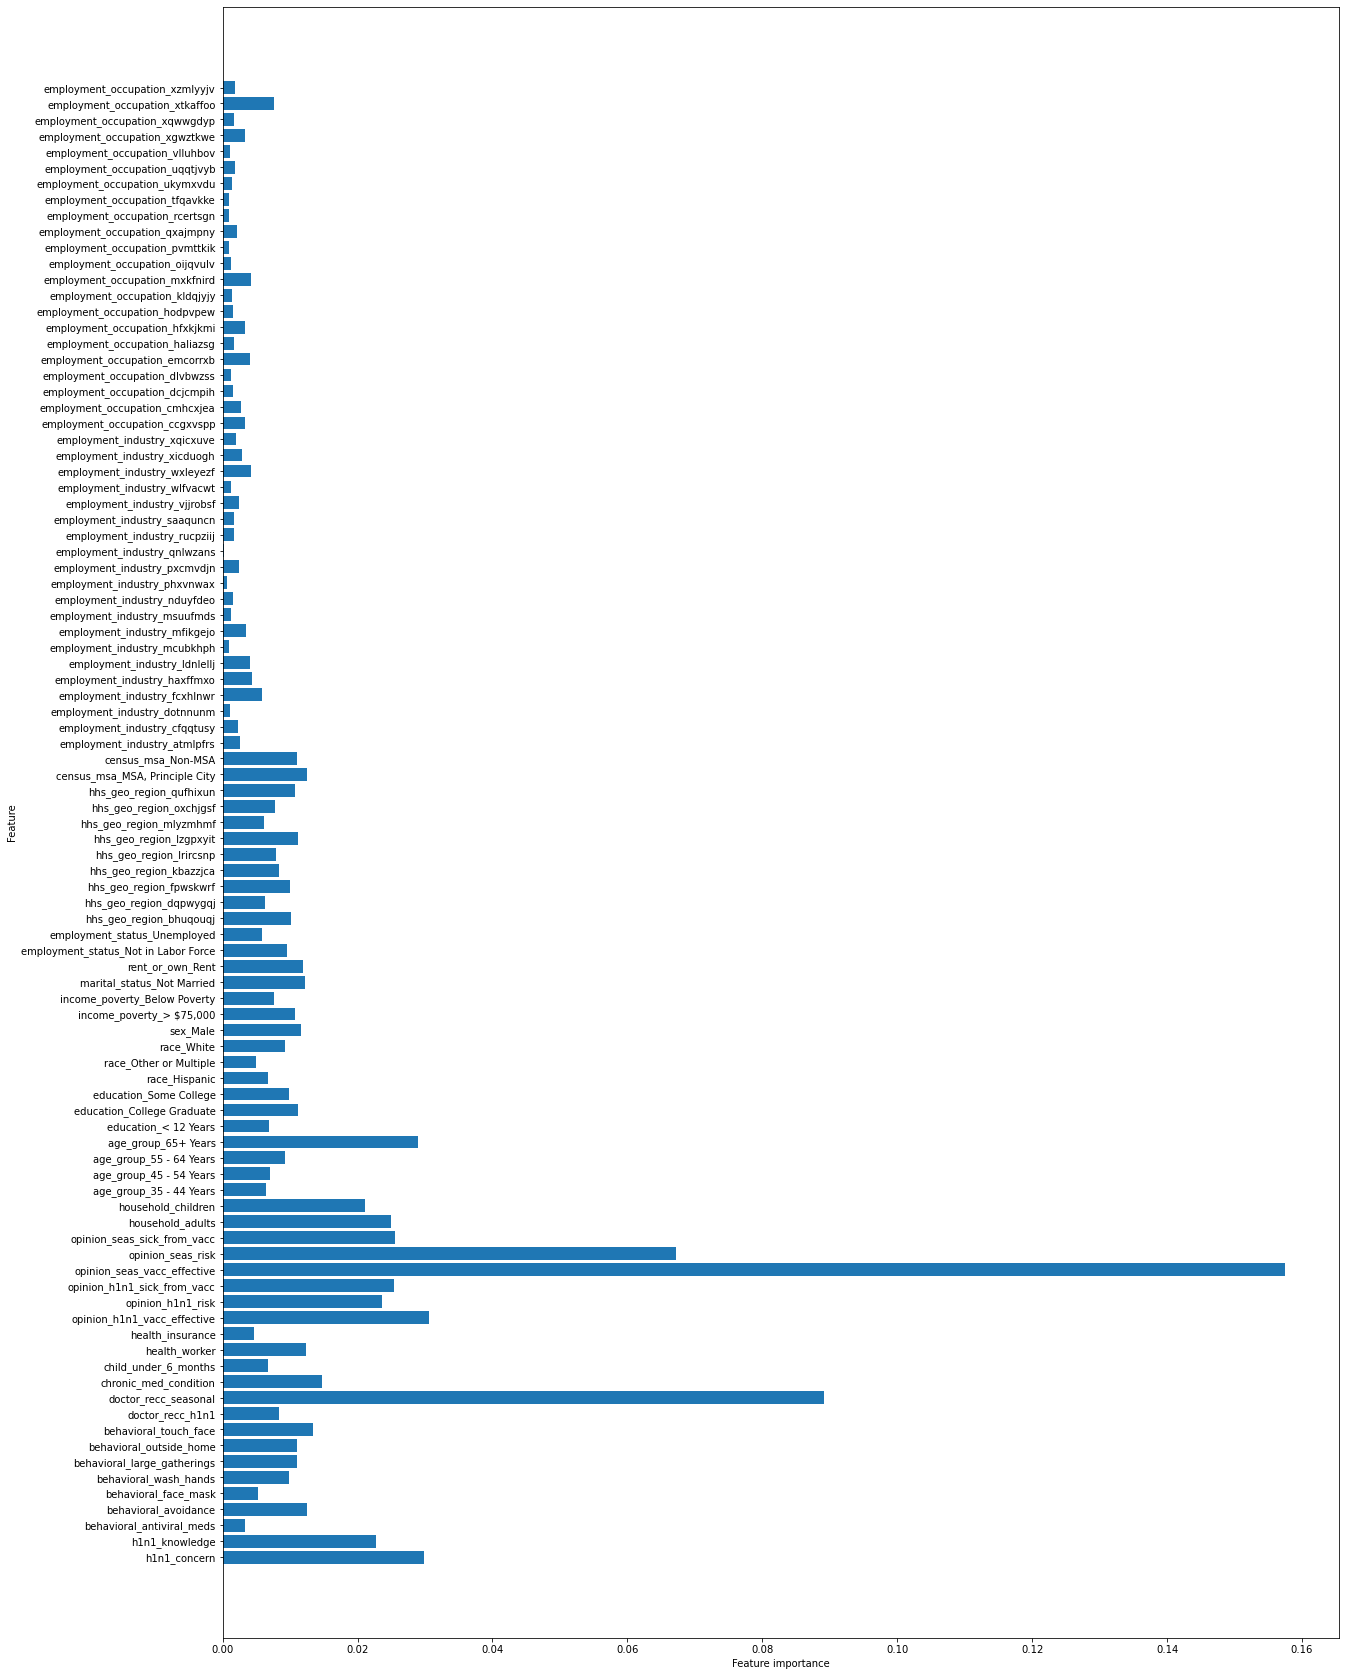

In [113]:
#Visualize feature importance for 
def plot_feature_importances(model):
    n_features = X_train_dummied.shape[1]
    plt.figure(figsize=(20,30))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_dummied.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


plot_feature_importances(baseline_tree)

In [115]:
def all_metrics(y_actuals, y_hats, y_score=None, model_name=None, keep_score=False, save_fig=False):
    """
    This function takes in y_data either as single dataframes or in groups
    as lists and returns recall, precision, accuracy, and f1 score. 
    If y_score is provided, an AUC score will also be calculated.
    If a name for the model is supplied and keep_score is set to True,
    that name along with scores are stored in a model dictionary for later use. 
    
    y_actuals: array/dataframe or a list of arrays/dataframes
    
    y_hats: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    y_score: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    model_name: string or list of strings. If y_actuals is 
    single array/dataframe, then string. If y_actuals is list, then
    list of same length.
    
    keep_score: bool, saves scores in a score dictionary
    
    save_fig: bool, exports graph to graph folder
    
    Note: save_fig is only supported for single models.
    
    """
    if type(y_actuals) == list:
        if len(y_actuals) != len(y_hats):
            print('The size of each list for y_tests and y_hats needs to be the same size.')
            return
        elif model_name and len(y_actuals) != len(model_name):
            print('The number of names does not match the number of models.')
            return
        else:
            all_scores = {}
            confusion_matrices = []
            for i in range(len(y_actuals)):
                y_actual = y_actuals[i]
                y_hat = y_hats[i]
                model_scores = {}
                cf_matrix = confusion_matrix(y_actual, y_hat)
                model_scores['recall'] = recall_score(y_actual, y_hat)
                model_scores['precision'] = precision_score(y_actual, y_hat)
                model_scores['accuracy'] = accuracy_score(y_actual, y_hat)
                model_scores['f1'] = f1_score(y_actual, y_hat)
                if y_score:
                    model_scores['AUC'] = roc_auc_score(y_actual, y_score[i][:,1])
                
                if model_name:
                    all_scores[model_name[i]] = model_scores
                    model_scoring_dict[model_name[i]] = model_scores
                    if keep_score:
                        model_scoring_dict[model_name[i]] = model_scores
                else:
                    all_scores[f'model number {i+1}'] = model_scores
                    
                confusion_matrices.append(cf_matrix)
        
        row = len(all_scores) // 3
        col = len(all_scores) % 3
        
        if len(all_scores) < 4:
            ncols=len(all_scores)
            nrows=1
        else:
            ncols=3
            if col != 0:
                nrows=row+1
            else:
                nrows=row
                
        sns.set_context('talk')
        fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
        
        for i, model in zip(range(len(all_scores)), all_scores):
            group_names = ['True Neg','False Pos','False Neg','True Pos']
            categories = ['No vaccine', 'Vaccine']

            group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrices[i].flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
            labels = np.asarray(labels).reshape(2,2)

            row = i // 3
            col = i % 3
            
            if nrows < 2:
                ax = axes[col]
            else:
                ax = axes[row][col]
            sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
            ax.set_ylabel('Actual')
            ax.set_yticklabels(ax1.get_yticklabels(), va="center")
            ax.set_xlabel('Predicted')
        
            if model_name:
                ax.set_title(model_name[i])
            else:
                ax.set_title('Model Performance')
                
        plt.tight_layout()        

        
        for model in all_scores:
            print('Recall for {}:    {}'.format(model, all_scores[model]['recall']))
        print('')
        for model in all_scores:
            print('Precision for {}: {}'.format(model, all_scores[model]['precision']))
        print('')
        for model in all_scores:
            print('Accuracy for {}:  {}'.format(model, all_scores[model]['accuracy']))
        print('')
        for model in all_scores:
            print('F1 score for {}:  {}'.format(model, all_scores[model]['f1']))
        if y_score:
            print('')
            for model in all_scores:
                print('AUROC for {}:     {}'.format(model, all_scores[model]['AUC']))
            
    else:
        if model_name and type(model_name) != str:
            print('There should only be one model name, and it should be a string.')
            return
        else:
            all_scores = {}
            model_scores = {}
            cf_matrix = confusion_matrix(y_actuals, y_hats)
            model_scores['recall'] = recall_score(y_actuals, y_hats)
            model_scores['precision'] = precision_score(y_actuals, y_hats)
            model_scores['accuracy'] = accuracy_score(y_actuals, y_hats)
            model_scores['f1'] = f1_score(y_actuals, y_hats)
            if y_score is not None:
                model_scores['AUC'] = roc_auc_score(y_actuals, y_score[:,1])
                
            if model_name:
                if keep_score:
                    model_scoring_dict[model_name] = model_scores
                print(f'Scores for {model_name}:')
            else:
                all_scores['model'] = model_scores
                print(f'Scores for this model:')
            
        cf_matrix = confusion_matrix(y_actuals, y_hats)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        categories = ['No vaccine', 'Vaccine']

        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)

        sns.set_context('talk')
        fig, ax = plt.subplots(figsize=(8,6))

        sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
        ax.set_ylabel('Actual')
        ax.set_yticklabels(ax.get_yticklabels(), va="center")
        ax.set_xlabel('Predicted')
        if model_name:
            ax.set_title(model_name)
        else:
            ax.set_title('Model Performance')
        
        if save_fig:
            fig.savefig('./graphs/{}'.format(model_name if model_name else 'rename_me'), dpi=300, transparent=False, bbox_inches='tight');
        
        print('Recall:    {}'.format(model_scores['recall']))
        print('Precision: {}'.format(model_scores['precision']))
        print('Accuracy:  {}'.format(model_scores['accuracy']))
        print('F1 score:  {}'.format(model_scores['f1']))
        if y_score is not None:
            print('AUROC:     {}'.format(model_scores['AUC']))

In [116]:
y_hat_ssnl = baseline_tree.predict(X_test_dummied)
y_proba_ssnl = baseline_tree.predict_proba(X_test_dummied)

Scores for baseline_tree:
Recall:    0.6794509487283004
Precision: 0.6691848906560636
Accuracy:  0.6956196181205541
F1 score:  0.674278846153846
AUROC:     0.694524776283871


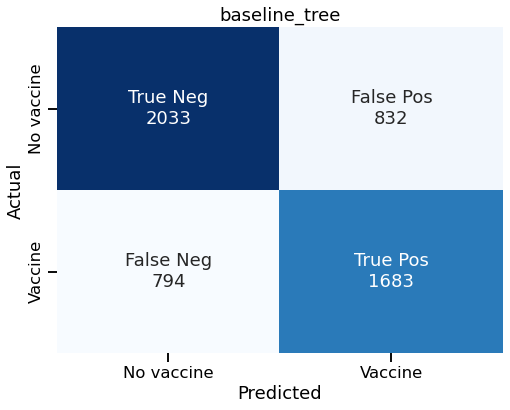

In [117]:
all_metrics(y_test_ssnl, y_hat_ssnl, y_score=y_proba_ssnl, model_name="baseline_tree", keep_score=False, save_fig=False)

# Bagged Trees

In [118]:
from sklearn.ensemble import BaggingClassifier
bagged_tree = BaggingClassifier()

bagged_tree.fit(X_train_dummied, y_train_ssnl)
bagged_tree.score(X_train_dummied, y_train_ssnl)

0.9828691785630704

In [119]:
# Score for baseline bagged tree -- Seasonal Flu test data
bagged_tree.score(X_test_dummied, y_test_ssnl)

0.7478472482216398

In [120]:
y_hat_ssnl = bagged_tree.predict(X_test_dummied)
y_proba_ssnl = bagged_tree.predict_proba(X_test_dummied)

Scores for bagged_tree:
Recall:    0.6786435203875656
Precision: 0.7531362007168458
Accuracy:  0.7478472482216398
F1 score:  0.713952006795498
AUROC:     0.8128934187544608


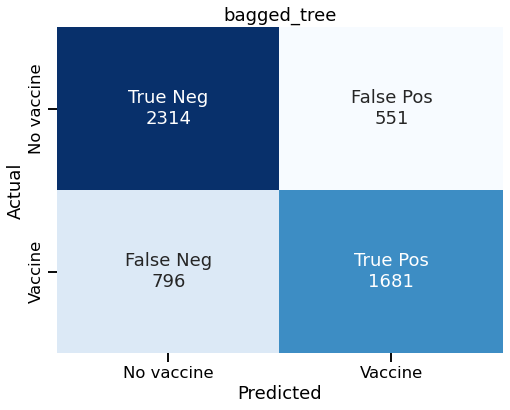

In [121]:
all_metrics(y_test_ssnl, y_hat_ssnl, y_score=y_proba_ssnl, model_name="bagged_tree", keep_score=False, save_fig=False)

In [123]:
#Another bagged tree with more estimators
bagged_tree2 = BaggingClassifier(n_estimators=20)

bagged_tree2.fit(X_train_dummied, y_train_ssnl)
bagged_tree2.score(X_train_dummied, y_train_ssnl)

0.9957875029253452

In [124]:
# Score for bagged trees 2 -- Seasonal flu test data
bagged_tree2.score(X_test_dummied, y_test_ssnl)

0.7585174092100337

In [125]:
y_hat_ssnl = bagged_tree2.predict(X_test_dummied)
y_proba_ssnl = bagged_tree2.predict_proba(X_test_dummied)

Scores for bagged_tree2:
Recall:    0.7109406540169559
Precision: 0.7541755888650964
Accuracy:  0.7585174092100337
F1 score:  0.7319201995012469
AUROC:     0.82443140064862


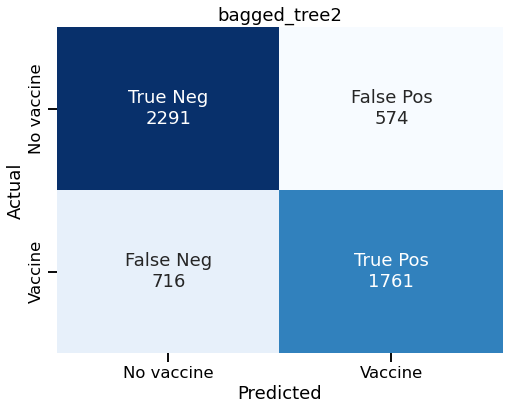

In [126]:
all_metrics(y_test_ssnl, y_hat_ssnl, y_score=y_proba_ssnl, model_name="bagged_tree2", keep_score=False, save_fig=False)

# Random Forest

In [127]:
forest1 = RandomForestClassifier()

forest1.fit(X_train_dummied, y_train_ssnl)
forest1.score(X_train_dummied, y_train_ssnl)

1.0

In [128]:
# Score for Random Forest 1 -- Seasonal flu test data
forest1.score(X_test_dummied, y_test_ssnl)

0.7755522276301011

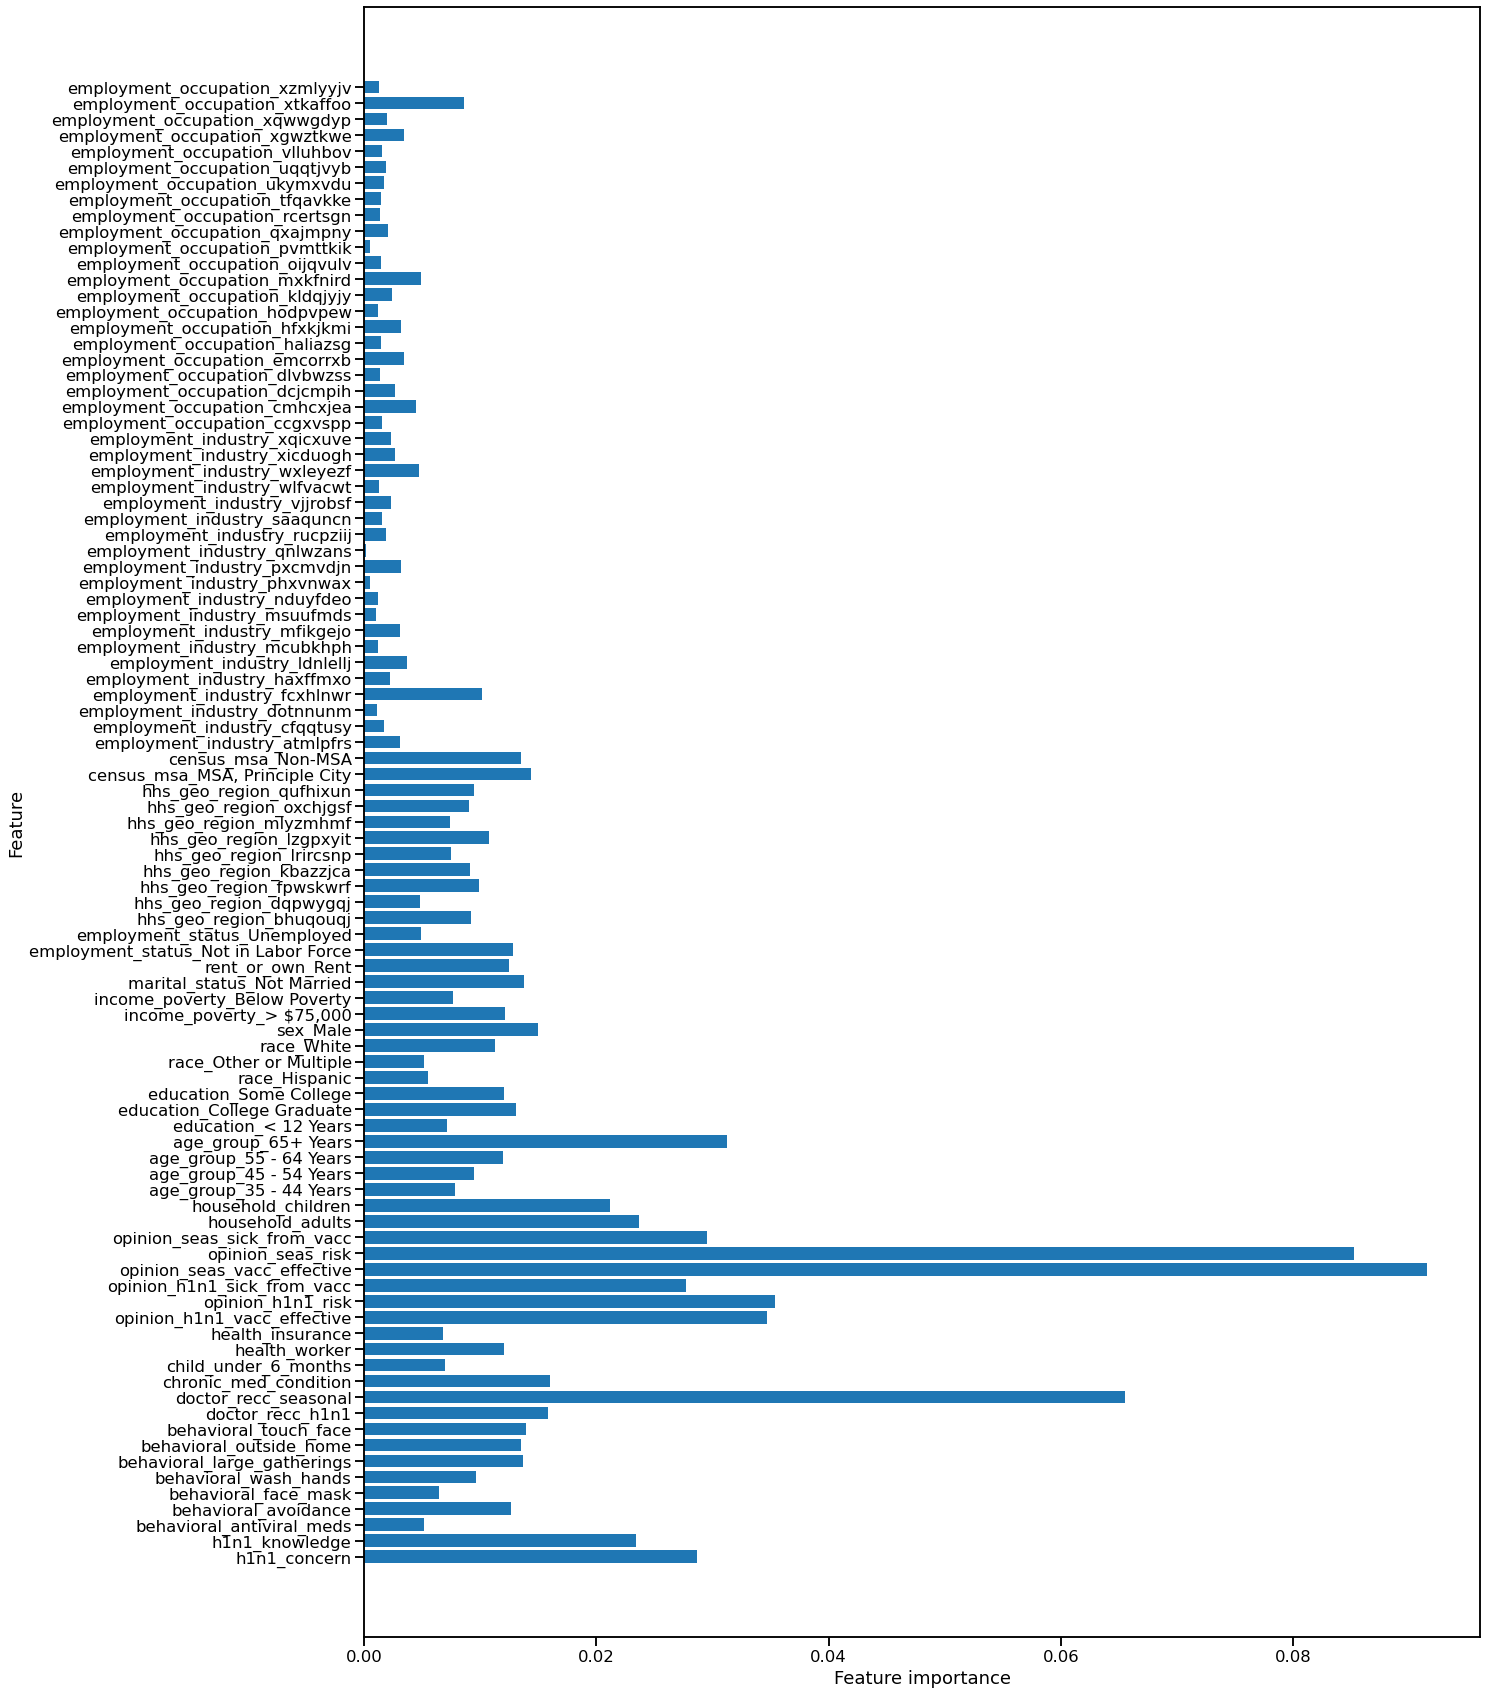

In [129]:
plot_feature_importances(forest1)

In [130]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(forest1, random_state=42).fit(X_test_dummied, y_test_ssnl)
eli5.show_weights(perm, feature_names = X_test_dummied.columns.tolist())

Weight,Feature
0.0482 ± 0.0096,opinion_seas_risk
0.0410 ± 0.0079,opinion_seas_vacc_effective
0.0396 ± 0.0075,doctor_recc_seasonal
0.0187 ± 0.0043,age_group_65+ Years
0.0051 ± 0.0018,health_worker
0.0046 ± 0.0041,opinion_seas_sick_from_vacc
0.0031 ± 0.0016,household_children
0.0026 ± 0.0035,h1n1_knowledge
0.0020 ± 0.0007,employment_industry_haxffmxo
0.0019 ± 0.0024,employment_industry_fcxhlnwr


In [131]:
y_hat_ssnl = forest1.predict(X_test_dummied)
y_proba_ssnl = forest1.predict_proba(X_test_dummied)

Scores for forest1:
Recall:    0.7383932176019379
Precision: 0.7684873949579832
Accuracy:  0.7755522276301011
F1 score:  0.7531397982293596
AUROC:     0.8427760880026436


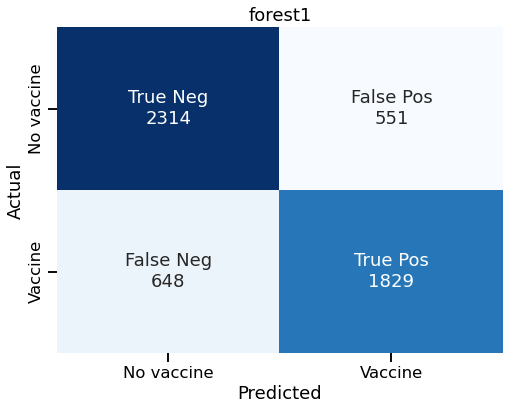

In [132]:
all_metrics(y_test_ssnl, y_hat_ssnl, y_score=y_proba_ssnl, model_name="forest1", keep_score=False, save_fig=False)

# Grid Search with Random Forest

In [134]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 10],
}

In [241]:
# Instantiate GridSearchCV
dt_grid_search1 = GridSearchCV(forest1, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
dt_grid_search1.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30]},
             return_train_score=True)

In [242]:
np.mean(dt_grid_search1.cv_results_['mean_train_score'])

0.934741384078718

In [243]:
# Score for Grid Search1 -- Seasonal flu test data
dt_grid_search1.score(X_test_dummied, y_test_ssnl)

0.7779857731186821

In [246]:
dt_grid_search1.best_params_

{'criterion': 'entropy', 'max_depth': 30}

In [252]:
#increasing max_depth options
dt_param_grid2 = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
}

In [253]:
# Instantiate GridSearchCV
dt_grid_search2 = GridSearchCV(forest1, dt_param_grid2, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
dt_grid_search2.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30]},
             return_train_score=True)

In [254]:
np.mean(dt_grid_search2.cv_results_['mean_train_score'])

0.9347452999651961

In [255]:
# Score for Grid Search2 -- Seasonal flu test data
dt_grid_search2.score(X_test_dummied, y_test_ssnl)

0.7744290527892175

In [256]:
dt_grid_search2.best_params_

{'criterion': 'gini', 'max_depth': 30}

In [247]:
#keeping gini and max_depth=30; adding new hyperparameters to test
dt_param_grid3 = {
    'criterion': ['gini'],
    'max_depth': [30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4, 6]
}

In [248]:
# Instantiate GridSearchCV
dt_grid_search3 = GridSearchCV(forest1, dt_param_grid3, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
dt_grid_search3.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [30],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [5, 10]},
             return_train_score=True)

In [249]:
np.mean(dt_grid_search3.cv_results_['mean_train_score'])

0.874015108272114

In [250]:
# Score for Grid Search3 -- Seasonal flu test data
dt_grid_search3.score(X_test_dummied, y_test_ssnl)

0.7779857731186821

In [251]:
dt_grid_search3.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'min_samples_leaf': 4,
 'min_samples_split': 5}

In [257]:
#refining min_samples_split and min_samples_leaf
dt_param_grid4 = {
    'criterion': ['gini'],
    'max_depth': [30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4, 6]
}

In [258]:
# Instantiate GridSearchCV
dt_grid_search4 = GridSearchCV(forest1, dt_param_grid4, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
dt_grid_search4.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [30],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 4, 6]},
             return_train_score=True)

In [259]:
np.mean(dt_grid_search4.cv_results_['mean_train_score'])

0.9060105885197945

In [260]:
# Score for Grid Search4 -- Seasonal flu test data
dt_grid_search4.score(X_test_dummied, y_test_ssnl)

0.7768625982777986

In [261]:
dt_grid_search4.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'min_samples_leaf': 4,
 'min_samples_split': 4}

In [263]:
#concerned about overfitting, going to bring the max_depth down and try out max_features
dt_param_grid5 = {
    'criterion': ['gini'],
    'max_depth': [15, 20, 25],
    'min_samples_split': [4],
    'min_samples_leaf': [2],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [264]:
# Instantiate GridSearchCV
dt_grid_search5 = GridSearchCV(forest1, dt_param_grid5, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
dt_grid_search5.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [15, 20, 25],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2], 'min_samples_split': [4]},
             return_train_score=True)

In [265]:
np.mean(dt_grid_search5.cv_results_['mean_train_score'])

0.9112411265382581

In [266]:
# Score for Grid Search5 -- Seasonal flu test data
dt_grid_search5.score(X_test_dummied, y_test_ssnl)

0.7761138150505429

In [267]:
dt_grid_search5.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 4}

In [268]:
dt_param_grid6 = {
    'criterion': ['gini'],
    'max_depth': [25],
    'min_samples_split': [4],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'max_leaf_nodes': [10, 15, 20, 30],
    'n_estimators': [75, 100, 200]
}

In [269]:
# Instantiate GridSearchCV
dt_grid_search6 = GridSearchCV(forest1, dt_param_grid6, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
dt_grid_search6.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [25],
                         'max_features': ['sqrt'],
                         'max_leaf_nodes': [10, 15, 20, 30],
                         'min_samples_leaf': [2], 'min_samples_split': [4],
                         'n_estimators': [75, 100, 200]},
             return_train_score=True)

In [270]:
np.mean(dt_grid_search6.cv_results_['mean_train_score'])

0.769502269984076

In [271]:
# Score for Grid Search6 -- Seasonal flu test data
dt_grid_search6.score(X_test_dummied, y_test_ssnl)

0.7613253463122426

In [272]:
dt_grid_search6.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'sqrt',
 'max_leaf_nodes': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 200}

In [273]:
dt_param_grid7 = {
    'criterion': ['gini'],
    'max_depth': [25],
    'min_samples_split': [4],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'max_leaf_nodes': [30, 40, 50],
    'n_estimators': [200]
}

In [274]:
# Instantiate GridSearchCV
dt_grid_search7 = GridSearchCV(forest1, dt_param_grid7, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
dt_grid_search7.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [25],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [30, 40, 50],
                         'min_samples_leaf': [2], 'min_samples_split': [4],
                         'n_estimators': [200]},
             return_train_score=True)

In [275]:
np.mean(dt_grid_search7.cv_results_['mean_train_score'])

0.7785864209320512

In [276]:
# Score for Grid Search7 -- Seasonal flu test data
dt_grid_search7.score(X_test_dummied, y_test_ssnl)

0.7652564582553351

In [277]:
dt_grid_search7.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 200}

In [278]:
#Best parameters from all these grid searches

best_forest = RandomForestClassifier(criterion='gini', max_depth=25, min_samples_leaf=2, min_samples_split=4)

best_forest.fit(X_train_dummied, y_train_ssnl)
best_forest.score(X_train_dummied, y_train_ssnl)

0.9336297683126609

In [279]:
# Score for Best Forest -- Seasonal flu test data
best_forest.score(X_test_dummied, y_test_ssnl)

0.7766754024709847

In [196]:
perm = PermutationImportance(best_forest, random_state=42).fit(X_test_dummied, y_test_ssnl)
eli5.show_weights(perm, feature_names = X_test_dummied.columns.tolist())

Weight,Feature
0.0492 ± 0.0087,opinion_seas_risk
0.0410 ± 0.0075,doctor_recc_seasonal
0.0394 ± 0.0044,opinion_seas_vacc_effective
0.0167 ± 0.0027,age_group_65+ Years
0.0036 ± 0.0019,opinion_seas_sick_from_vacc
0.0022 ± 0.0017,health_worker
0.0021 ± 0.0017,doctor_recc_h1n1
0.0021 ± 0.0004,employment_occupation_dcjcmpih
0.0021 ± 0.0029,h1n1_knowledge
0.0018 ± 0.0003,employment_industry_haxffmxo


In [280]:
y_hat_ssnl = best_forest.predict(X_test_dummied)
y_proba_ssnl = best_forest.predict_proba(X_test_dummied)

Scores for best_forest:
Recall:    0.7420266451352443
Precision: 0.7683946488294314
Accuracy:  0.7766754024709847
F1 score:  0.7549804888067365
AUROC:     0.8484974153133787


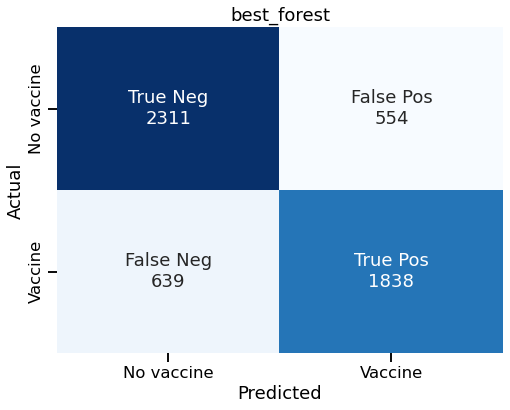

In [281]:
all_metrics(y_test_ssnl, y_hat_ssnl, y_score=y_proba_ssnl, model_name="best_forest", keep_score=False, save_fig=False)

# Extra Trees

In [202]:
>>> from sklearn.ensemble import ExtraTreesClassifier
extra = ExtraTreesClassifier(random_state=42)
extra.fit(X_train_dummied, y_train_ssnl)

ExtraTreesClassifier(random_state=42)

In [205]:
extra.score(X_train_dummied, y_train_ssnl)

1.0

In [207]:
# Score for Extra Trees 1 -- Seasonal flu test data
extra.score(X_test_dummied, y_test_ssnl)

0.7697491576188693

In [208]:
y_hat_ssnl = extra.predict(X_test_dummied)
y_proba_ssnl = extra.predict_proba(X_test_dummied)

Scores for extra:
Recall:    0.7266855066612838
Precision: 0.764980875478113
Accuracy:  0.7697491576188693
F1 score:  0.7453416149068322
AUROC:     0.8420669460960558


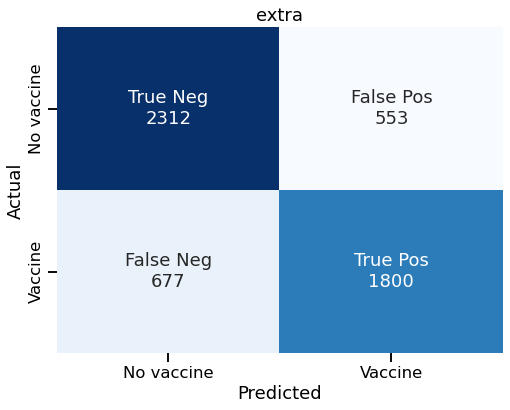

In [209]:
all_metrics(y_test_ssnl, y_hat_ssnl, y_score=y_proba_ssnl, model_name="extra", keep_score=False, save_fig=False)

In [211]:
extra2 = ExtraTreesClassifier(max_features='sqrt', max_depth=8, min_samples_leaf=2, bootstrap=True)
extra2.fit(X_train_dummied, y_train_ssnl)

ExtraTreesClassifier(bootstrap=True, max_depth=8, max_features='sqrt',
                     min_samples_leaf=2)

In [212]:
extra2.score(X_train_dummied, y_train_ssnl)

0.780435291364381

In [213]:
# Score for Extra Trees 2 -- Seasonal flu test data
extra2.score(X_test_dummied, y_test_ssnl)

0.7639460876076376

# Grid Search with Extra Trees

In [215]:
extra_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True]
}

In [216]:
# Instantiate GridSearchCV
extra_grid = GridSearchCV(extra, extra_param_grid, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
extra_grid.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [5, 10]},
             return_train_score=True)

In [217]:
np.mean(extra_grid.cv_results_['mean_train_score'])

0.7495546543090797

In [218]:
# Score for Extra Trees Grid Search1 -- Seasonal flu test data
extra_grid.score(X_test_dummied, y_test_ssnl)

0.7587046050168477

In [219]:
extra_grid.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [220]:
extra_param_grid2 = {
    'criterion': ['gini'],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'bootstrap': [True]
}

In [221]:
# Instantiate GridSearchCV
extra_grid2 = GridSearchCV(extra, extra_param_grid2, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
extra_grid2.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [6, 8, 10], 'max_features': ['auto'],
                         'min_samples_leaf': [2],
                         'min_samples_split': [2, 5, 7]},
             return_train_score=True)

In [222]:
np.mean(extra_grid2.cv_results_['mean_train_score'])

0.7870764206317129

In [223]:
# Score for Extra Trees Grid Search2 -- Seasonal flu test data
extra_grid2.score(X_test_dummied, y_test_ssnl)

0.7693747660052415

In [224]:
extra_grid2.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 7}

In [226]:
extra_param_grid3 = {
    'criterion': ['gini'],
    'max_depth': [10, 15, 20],
    'min_samples_split': [7, 9, 14],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'bootstrap': [True]
}

In [227]:
# Instantiate GridSearchCV
extra_grid3 = GridSearchCV(extra, extra_param_grid3, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
extra_grid3.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [10, 15, 20], 'max_features': ['auto'],
                         'min_samples_leaf': [2],
                         'min_samples_split': [7, 9, 14]},
             return_train_score=True)

In [228]:
np.mean(extra_grid3.cv_results_['mean_train_score'])

0.8475309688767526

In [229]:
# Score for Extra Trees Grid Search3 -- Seasonal flu test data
extra_grid3.score(X_test_dummied, y_test_ssnl)

0.7763010108573568

In [230]:
extra_grid3.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 9}

In [231]:
extra_param_grid4 = {
    'criterion': ['gini'],
    'max_depth': [20,25,30],
    'min_samples_split': [9],
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    'bootstrap': [True]
}

In [232]:
# Instantiate GridSearchCV
extra_grid4 = GridSearchCV(extra, extra_param_grid4, cv=3, return_train_score=True)

# Fit to the data --  Seasonal
extra_grid4.fit(X_train_dummied, y_train_ssnl)

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [20, 25, 30], 'max_features': ['auto'],
                         'min_samples_leaf': [2], 'min_samples_split': [9]},
             return_train_score=True)

In [234]:
np.mean(extra_grid4.cv_results_['mean_train_score'])

0.8932677826643003

In [235]:
# Score for Extra Trees Grid Search4 -- Seasonal flu test data
extra_grid4.score(X_test_dummied, y_test_ssnl)

0.7779857731186821

In [236]:
extra_grid4.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 9}

In [237]:
#Best parameters from all these Extra Trees grid searches

best_extra = ExtraTreesClassifier(max_features='sqrt', max_depth=25, min_samples_leaf=2, bootstrap=True, criterion='gini', min_samples_split=9)

best_extra.fit(X_train_dummied, y_train_ssnl)
best_extra.score(X_train_dummied, y_train_ssnl)

0.8940791013339574

In [238]:
# Score for Best Extra Trees -- Seasonal flu test data
best_extra.score(X_test_dummied, y_test_ssnl)

0.7744290527892175

In [239]:
y_hat_ssnl = best_extra.predict(X_test_dummied)
y_proba_ssnl = best_extra.predict_proba(X_test_dummied)

Scores for best_extra:
Recall:    0.7335486475575292
Precision: 0.7692633361558001
Accuracy:  0.7744290527892175
F1 score:  0.7509816077702004
AUROC:     0.8477239468731879


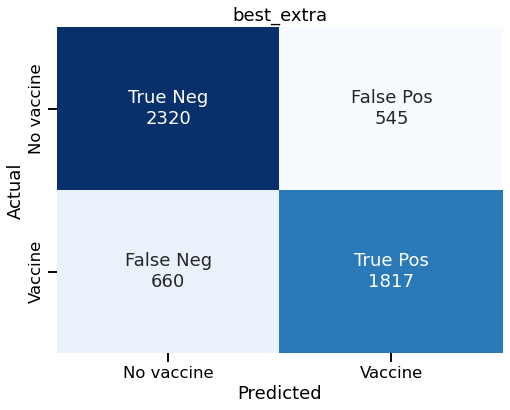

In [240]:
all_metrics(y_test_ssnl, y_hat_ssnl, y_score=y_proba_ssnl, model_name="best_extra", keep_score=False, save_fig=False)